# Use emcee to sample Lya posterior as a function of mean flux

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import lya_theory
import likelihood

## Setup Lya likelihood function

In [2]:
# read P1D measurement
#data=data_PD2013.P1D_PD2013(blind_data=True)
data=data_PD2013.P1D_PD2013(blind_data=True,zmin=2.1,zmax=4.7)
zs=data.z

In [5]:
basedir='../../p1d_emulator/sim_suites/emulator_512_18062019/'
#basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
p1d_label=None
skewers_label=None
undersample_z=1
paramList=["Delta2_p","mF","sigT_Mpc","gamma","kF_Mpc"]
max_arxiv_size=2000
kmax_Mpc=3.0
emu_type='polyGP'
if emu_type=='polyGP':
    emu=gp_emulator.PolyfitGPEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                kmax_Mpc=kmax_Mpc,verbose=True,paramList=paramList,train=True)
elif emu_type=='kGP':
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                               undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                               verbose=True,paramList=paramList,train=True)
elif emu_type=='linear':
    # specify parameters to emulate
    emulate_slope=False
    emulate_growth=False
    emulate_running=False
    emulate_pressure=True
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,kmax_Mpc=kmax_Mpc,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                emulate_slope=emulate_slope,emulate_running=emulate_running,
                                emulate_pressure=emulate_pressure,emulate_growth=emulate_growth,verbose=False)
elif emu_type=='NGP':
    emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                verbose=False)
else:
    raise ValueError('wrong emulator type '+emu_type)

latin hyper-cube data {'param_space': {'heat_amp': {'ip': 0, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$H_A$'}, 'heat_slo': {'ip': 1, 'min_val': -0.5, 'max_val': 0.5, 'latex': '$H_S$'}, 'z_rei': {'ip': 2, 'min_val': 6.0, 'max_val': 12.0, 'latex': '$z_r$'}}, 'nsamples': 6, 'samples': {'0': [1.125, -0.08333333333333337, 9.5], '1': [1.875, 0.25, 8.5], '2': [0.875, 0.08333333333333326, 10.5], '3': [1.375, -0.25, 6.5], '4': [0.625, 0.41666666666666663, 7.5], '5': [1.625, -0.4166666666666667, 11.5]}}
simulation suite has 6 samples
0 sample has sim params = [1.125, -0.08333333333333337, 9.5]
simulation has 20 redshifts
undersample_z = 1
../../p1d_emulator/sim_suites/emulator_512_18062019//sim_pair_0/sim_plus/p1d_0_Ns100_wM0.07.json snapshot does not have p1d
../../p1d_emulator/sim_suites/emulator_512_18062019//sim_pair_0/sim_plus/p1d_1_Ns100_wM0.07.json snapshot does not have p1d
../../p1d_emulator/sim_suites/emulator_512_18062019//sim_pair_0/sim_plus/p1d_2_Ns100_wM0.07.json snapshot does not

In [6]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=True)

Note: redshifts have been re-sorted (earliest first)


In [7]:
like=likelihood.Likelihood(data=data,theory=theory,verbose=True)

got parameters
g_star = 0.9677508579459803
f_star = 0.98136955784
Delta2_star = 0.360175905286
n_star = -2.29933566726
alpha_star = -0.216527037121
ln_tau_0 = -0.794580172414
ln_tau_1 = 3.18
ln_T0_0 = 9.39266192877
ln_T0_1 = 0.0
ln_gamma_0 = 0.336472236621
ln_gamma_1 = -0.2
ln_kF_0 = -1.77195684193
ln_kF_1 = 0.3
likelihood setup with 1 free parameters
1 free parameters


In [8]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.794580172414


In [9]:
# test likelihood function
values=[0.5]
like.log_prob(values=values)

0 2.2 model {'Delta2_p': 0.55651130145771688, 'n_p': -2.2994794185069685, 'alpha_p': -0.21637589659957746, 'f_p': 0.96522452450210083, 'mF': 0.83448643777956488, 'gamma': 1.4987891578368266, 'sigT_Mpc': 0.14317030489579091, 'kF_Mpc': 10.685853756322416}
1 2.4 model {'Delta2_p': 0.49488568402750766, 'n_p': -2.2994795015019927, 'alpha_p': -0.21637671767578953, 'f_p': 0.97065366319224333, 'mF': 0.80299190268821985, 'gamma': 1.4807261800728169, 'sigT_Mpc': 0.13961111388225106, 'kF_Mpc': 11.159400534093098}
2 2.6 model {'Delta2_p': 0.44280074273630693, 'n_p': -2.2994793009304835, 'alpha_p': -0.21637578130992885, 'f_p': 0.97499691285123324, 'mF': 0.76862970398372188, 'gamma': 1.4638953736277824, 'sigT_Mpc': 0.13623381682308353, 'kF_Mpc': 11.633837907034462}
3 2.8 model {'Delta2_p': 0.39841920050635804, 'n_p': -2.2994793725990892, 'alpha_p': -0.21637637290771081, 'f_p': 0.97850450521187982, 'mF': 0.73160691033963021, 'gamma': 1.4481509020115682, 'sigT_Mpc': 0.13303768341235486, 'kF_Mpc': 12.1

-1413.871513452254

In [10]:
#cProfile.run("like.log_prob(values=values,linP_Mpc_params=linP_Mpc_params)",sort='cumtime')

### Setup function to be called in MCMC

In [11]:
def log_prob(values,like,verbose=False):
    test_log_prob=like.log_prob(values=values)
    if np.isnan(test_log_prob):
        if verbose:
            print('parameter values outside hull',values)
        return -np.inf
    return test_log_prob

In [12]:
like.go_silent()

In [14]:
xs=np.linspace(0.0,1.0,100)
xmin=like.free_params[0].min_value
xmax=like.free_params[0].max_value
print(xmin,'< ln_tau_0 <',xmax)
print(np.exp(xmin),'< tau_0 <',np.exp(xmax))
print(np.exp(-np.exp(xmax)),'< <F> <',np.exp(-np.exp(xmin)))
mf=np.exp(-np.exp(xmin+xs*(xmax-xmin)))
lnps=[log_prob([x],like) for x in xs]

-1.5 < ln_tau_0 < -0.5
0.223130160148 < tau_0 < 0.606530659713
0.545239211893 < <F> < 0.800010713004


Text(0, 0.5, '$\\chi^2$')

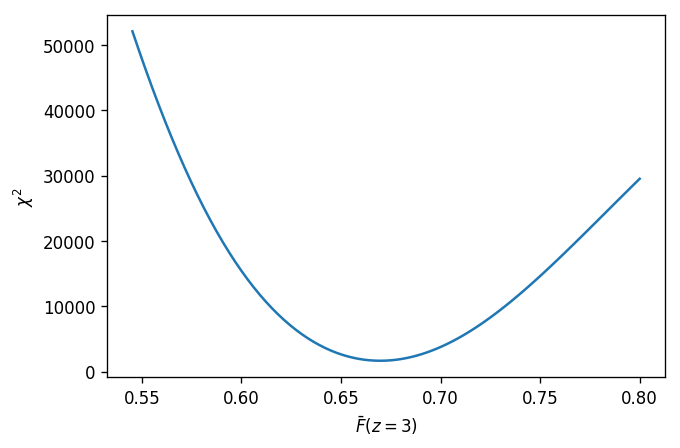

In [15]:
plt.plot(mf,-2.0*np.array(lnps))
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')

### Setup MCMC

In [16]:
# for now we'll have only one dimension (mean flux)
ndim=1
# setup initial walkers
nwalkers = 10
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [17]:
p0.flatten()

array([ 0.96265115,  0.51917906,  0.19272614,  0.01234295,  0.45533134,
        0.22904697,  0.0714287 ,  0.84303347,  0.14197983,  0.27236813])

In [18]:
# test function
log_prob(p0[0],like)

-20785.641308168142

In [19]:
# setup sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[like])

In [20]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 50)
print('finished burn-in at',pos.flatten(),prob)

finished burn-in at [ 0.58751321  0.58501476  0.58633668  0.58059488  0.58415834  0.58357146
  0.58300679  0.58289563  0.58318251  0.58240375] [-824.74509811 -824.63309405 -824.55632734 -827.09295131 -824.84540877
 -825.06449975 -825.33167898 -825.3907759  -825.2426139  -825.67794536]


In [21]:
# reset and run actual chains
sampler.reset()
nsteps=200
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 20 == 0:
        print(i,result[0].flatten())

0 [ 0.5868552   0.58556834  0.58558461  0.57981542  0.58407581  0.58202771
  0.5815169   0.58227798  0.58318251  0.58240375]
20 [ 0.58251448  0.5856128   0.58475592  0.5832726   0.5874349   0.58634921
  0.58315835  0.58289659  0.58999422  0.59077149]
40 [ 0.58275708  0.58853255  0.58617509  0.58249274  0.58751934  0.58441895
  0.58671411  0.58961067  0.58727734  0.58733149]
60 [ 0.58408035  0.5849791   0.58750236  0.58216264  0.58744101  0.58088392
  0.58563132  0.58465753  0.58447712  0.58343123]
80 [ 0.58815247  0.5844688   0.58984076  0.58507207  0.58927285  0.58252368
  0.58443481  0.58569825  0.58594713  0.58694929]
100 [ 0.58733836  0.58364497  0.58445026  0.58170097  0.58302577  0.5881402
  0.58477129  0.58829713  0.58234267  0.58387003]
120 [ 0.58754759  0.58499216  0.58744949  0.58725921  0.58437035  0.58819524
  0.58515147  0.58842931  0.58468826  0.58432896]
140 [ 0.58667345  0.58870948  0.58433727  0.58838294  0.58500955  0.58630693
  0.58725659  0.58557243  0.58823507  0.5

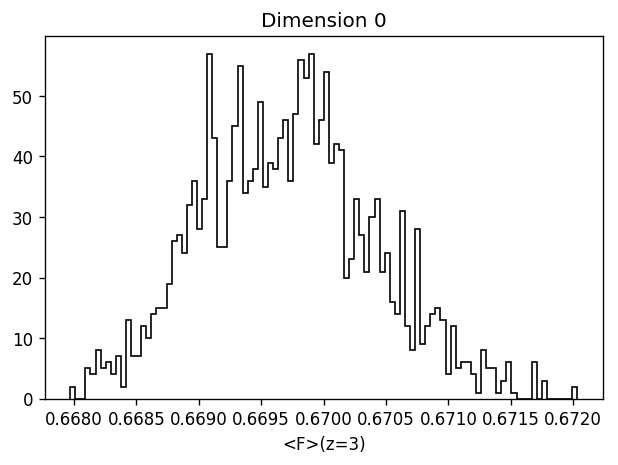

In [22]:
for i in range(ndim):
    plt.figure()
    mf=np.exp(-np.exp(xmin+sampler.flatchain[:,i]*(xmax-xmin)))
    plt.hist(mf, 100, color="k", histtype="step")
    plt.xlabel('<F>(z=3)')
    plt.title("Dimension {0:d}".format(i))

In [23]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.810


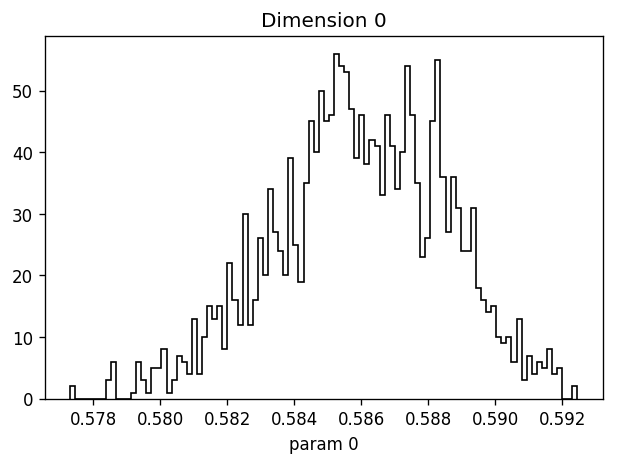

In [24]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.xlabel('param 0')
    plt.title("Dimension {0:d}".format(i))

In [25]:
# get best fit model
ind = np.unravel_index(np.argmax(sampler.lnprobability, axis=None), sampler.lnprobability.shape)
best_fit=sampler.chain[ind]

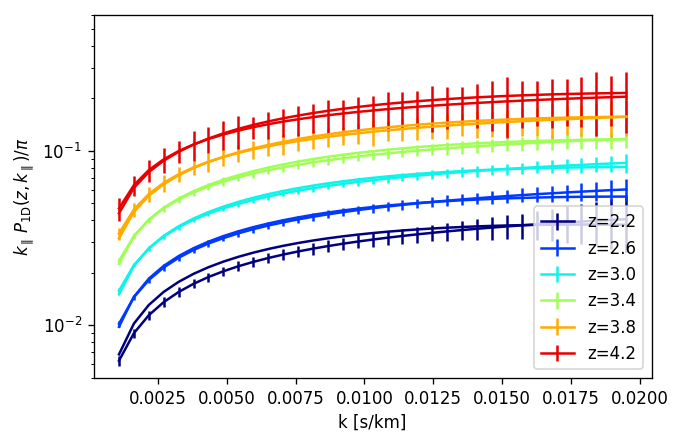

In [26]:
like.plot_p1d(plot_every_iz=2,values=best_fit)